# Nama : Anindhita Nisitasari

# Set The Data

In [ ]:
!pip install scikit-image==0.16.2
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install h5py==2.10.0
!pip install opencv-python
!pip install imgaug
!pip install IPython[all]

In [55]:
# install package
!pip install -q kaggle
from google.colab import files
import io
import zipfile
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [56]:
! chmod 600 /content/kaggle.json

In [57]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mahmoudreda55/satellite-image-classification

satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
import zipfile,os,shutil
local_zip = '/content/satellite-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [59]:
base_dir = '/tmp/data'
cloudy_dir = os.path.join(base_dir,'cloudy')
desert_dir = os.path.join(base_dir, 'desert')
green_dir = os.path.join(base_dir, 'green_area')
water_dir = os.path.join(base_dir, 'water')

In [60]:
cloudy_total = len(os.listdir(cloudy_dir))
desert_total = len(os.listdir(desert_dir))
green_total = len(os.listdir(green_dir))
water_total = len(os.listdir(water_dir))

# to know the amount of the data
print("Cloudy total image      : ",cloudy_total)
print("Desert total image      : ",desert_total)
print("Green Area total image  : ",green_total)
print("Water total image       : ",water_total)

Cloudy total image      :  1500
Desert total image      :  1131
Green Area total image  :  1500
Water total image       :  1500


In [61]:
val_size = 0.2

Train_datagen = ImageDataGenerator(
    rotation_range = 45,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 45,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

In [62]:
# Train dan Validation generator  dengan mode categorical
Train_generator = Train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


# Model

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [86]:
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.layers import Input

In [93]:
# Pembuatan Model dengan tipe Sequential
Model = Sequential(
    [
     # Activation menggunakan relu + softmax
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' , input_shape = (150,150,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),
     # Droupout
     Dropout(0.2),
     Dense(128, activation = 'relu'),
     Dense(4, activation='softmax')
    ]
)

In [94]:

# Penggunaan Optimizer 'Adam' dengan learning rate 0.00146
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [95]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 17, 17, 128)     

In [96]:
# Proses Training 
batch_size = 1

with tf.device("/device:GPU:0"):
  history = Model.fit(Train_generator, 
                    epochs =  100, 
                    steps_per_epoch = 50//batch_size, 
                    validation_data = Validation_generator, 
                    verbose = 1, 
                    validation_steps = 50//batch_size,
                    callbacks =[lr_schedule, tb_callback])
     
     


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.5624

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7fe815cee0d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7fe815cee0d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - 57s 1s/step - loss: 0.8169 - accuracy: 0.5624 - val_loss: 0.5007 - val_accuracy: 0.9038 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
50/50 [==============================] - 58s 1s/step - loss: 0.6502 - accuracy: 0.6456 - val_loss: 0.4109 - val_accuracy: 0.8800 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.00100000004

# Accuracy and Plot

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7fe82534c670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Saving train_10021.jpeg to train_10021 (2).jpeg
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7fe82534c670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 122ms/step


Prediction Result :  [1. 0. 0. 0.] 

Image Category : Cloudy


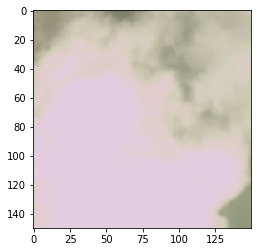

In [99]:
import numpy as np
from google.colab import files
from keras_preprocessing.image import load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras.utils as image
%matplotlib inline

# Upload File ke google colabs
uploaded = files.upload()

# pengkondisian
for file_upload in uploaded.keys():

  path = file_upload
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  # Membuat numpy vstack array untuk hasil prediksi 
  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  
  print("\n")
  print('Prediction Result : ',classes[0],'\n')

  if classes[0][0] == 1:
    print('Image Category : Cloudy')
  elif classes[0][1] == 1:
    print('Image Category : Desert')
  elif classes[1][1] == 1:
    print('Image Category : Green Area')
  else:
    print('Image Category : Water')

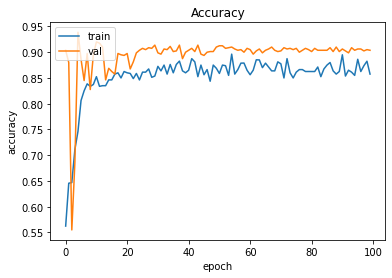

In [100]:
# Mengambil Nilai Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

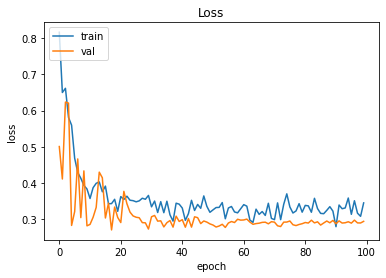

In [101]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save to TF-Lite

In [105]:
# Convert Model.
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()

# Save the model.
with open('RPS_model.tflite', 'wb') as f:
  f.write(tflite_model)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fe81c9734c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fe81c9734c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
